In [2]:
# Tratamiento de datos
# ===============================================================================
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Gráficos
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# API de Google Analytics
# ===============================================================================
from googleapiclient.discovery import build
from google.oauth2 import service_account
from oauth2client.service_account import ServiceAccountCredentials

# Importar contraseñas e id
# ===============================================================================
import os 
from dotenv import load_dotenv
load_dotenv()

# Guardar modelo
# ==============================================================================
import pickle

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Llamamos a la API
# ==============================================================================

def format_summary(response):
    try:
        # crea un index para row
        try: 
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except:
            row_index_named = None
        
        # extrae la columna names
        summary_column_names = [item['name'] for item in response['reports'][0]
                                ['columnHeader']['metricHeader']['metricHeaderEntries']]
    
        # Extrae la tabla de values
        summary_values = [element['metrics'][0]['values'] for element in response['reports'][0]['data']['rows']]
    
        df = pd.DataFrame(data = np.array(summary_values), 
                          index = row_index_named, 
                          columns = summary_column_names).astype('float')
    
    except:
        df = pd.DataFrame()
        
    return df

def format_pivot(response):
    try:
        # extrae la tabla de values
        pivot_values = [item['metrics'][0]['pivotValueRegions'][0]['values'] for item in response['reports'][0]
                        ['data']['rows']]
        
        # Crea un index para las columnas
        top_header = [item['dimensionValues'] for item in response['reports'][0]
                      ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        column_metrics = [item['metric']['name'] for item in response['reports'][0]
                          ['columnHeader']['metricHeader']['pivotHeaders'][0]['pivotHeaderEntries']]
        array = np.concatenate((np.array(top_header),
                                np.array(column_metrics).reshape((len(column_metrics),1))), 
                               axis = 1)
        column_index = pd.MultiIndex.from_arrays(np.transpose(array))
        
        # Crea un index para las rows
        try:
            row_index_names = response['reports'][0]['columnHeader']['dimensions']
            row_index = [ element['dimensions'] for element in response['reports'][0]['data']['rows'] ]
            row_index_named = pd.MultiIndex.from_arrays(np.transpose(np.array(row_index)), 
                                                        names = np.array(row_index_names))
        except: 
            row_index_named = None
        # Crea un df
        df = pd.DataFrame(data = np.array(pivot_values), 
                          index = row_index_named, 
                          columns = column_index).astype('float')
    except:
        df = pd.DataFrame()
    return df

def format_report(response):
    summary = format_summary(response)
    pivot = format_pivot(response)
    if pivot.columns.nlevels == 2:
        summary.columns = [['']*len(summary.columns), summary.columns]
    
    return(pd.concat([summary, pivot], axis = 1))

def run_report(body, credentials_file):
    # Crea las credenciales
    credentials = service_account.Credentials.from_service_account_file(credentials_file, 
                                scopes = ['https://www.googleapis.com/auth/analytics.readonly'])
    # Crea el servicio
    service = build('analyticsreporting', 'v4', credentials=credentials)
    
    
    response = service.reports().batchGet(body=body).execute()
    
    return(format_report(response))

In [4]:
# Cargamos las credenciales
# ==============================================================================

your_view_id = os.getenv("your_view_id") 
ga_keys = os.getenv("ga_keys") 

In [30]:
# Cargamos a las dimensiones que queremos sacar de GA y el periodo con la función de llamada a la API
# ==============================================================================

# Definimos 3 rangos de fechas ya que solo nos deja sacar datos con un límite de 1000
date_ranges = [{'startDate': '2022-01-01', 'endDate': '2022-12-31'},
               {'startDate': '2022-05-06', 'endDate': '2022-12-31'},
               {'startDate': '2022-09-08', 'endDate': '2022-12-31'}]

# Definimos la métricas que queremos sacar
metrics = [{'expression': 'ga:sessions'},
           {'expression': 'ga:avgSessionDuration'},
           {'expression': 'ga:users'},
           {'expression': 'ga:newUsers'}]
dimensions = [{'name': 'ga:date'},
              {'name': 'ga:channelGrouping'}]

# Creamos una lista vacía para contener al df
report_list = []

# Itera sobre los rangos de fechas y hace las llamadas a la API
for date_range in date_ranges:
    body = {'reportRequests': [{'viewId': your_view_id, 
                                'dateRanges': [date_range],
                                'metrics': metrics,
                                'dimensions': dimensions}]}
    report = run_report(body, ga_keys).reset_index()
    report_list.append(report)

# Concatena los df en la lista
report_day = pd.concat(report_list, ignore_index=True)

In [34]:
report_day.head()

,ga:date,ga:channelGrouping,ga:sessions,ga:avgSessionDuration,ga:users,ga:newUsers
0,20220101,(Other),786.0,99.844784,603.0,143.0
1,20220101,Direct,174303.0,142.536296,121929.0,23799.0
2,20220101,Display,314.0,161.512739,177.0,0.0
3,20220101,Email,22.0,83.090909,20.0,0.0
4,20220101,Organic Search,643900.0,97.988424,486486.0,75736.0


In [25]:
# Almacenamos el resultado en un pickle
# ==============================================================================

with open(f'../data/weahter_day_plot.pkl', 'wb') as adata:
        pickle.dump(report_day, adata)

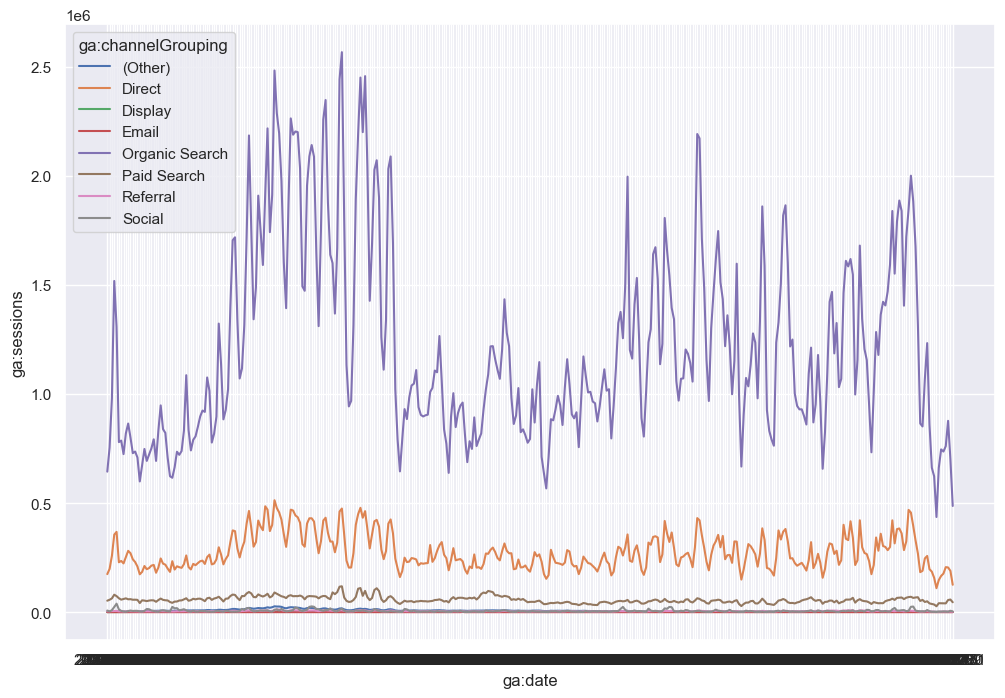

In [21]:
# Visualizamos las sesiones diarias
# ==============================================================================

sns.set(rc={'figure.figsize':(12,8)})
plot_data = report_day.loc[:, ["ga:users"]]
sns.lineplot(data = report_day, y = "ga:sessions", x = 'ga:date', hue = 'ga:channelGrouping');

In [22]:
# Cargamos a las dimensiones que queremos sacar de GA y el periodo con la fucnión de llamada de la API
# ==============================================================================

body = body = {'reportRequests': [{'viewId': your_view_id, 
                            'dateRanges': [{'startDate': '2022-01-01', 'endDate': '2022-12-31'}],
                            'metrics': [{'expression': 'ga:sessions'},
                                        {"expression": "ga:avgSessionDuration"},
                                        {"expression": "ga:users"},
                                        {"expression": "ga:newUsers"}],
                            'dimensions': [{'name': 'ga:yearMonth'},
                                           {"name": "ga:channelGrouping"}],
                          }]}

report_month = run_report(body, ga_keys).reset_index()

# Guardamos el resultado en un csv para unirlo a nuestro df original
report_month.to_csv('../data/GA_audience_2022.csv')

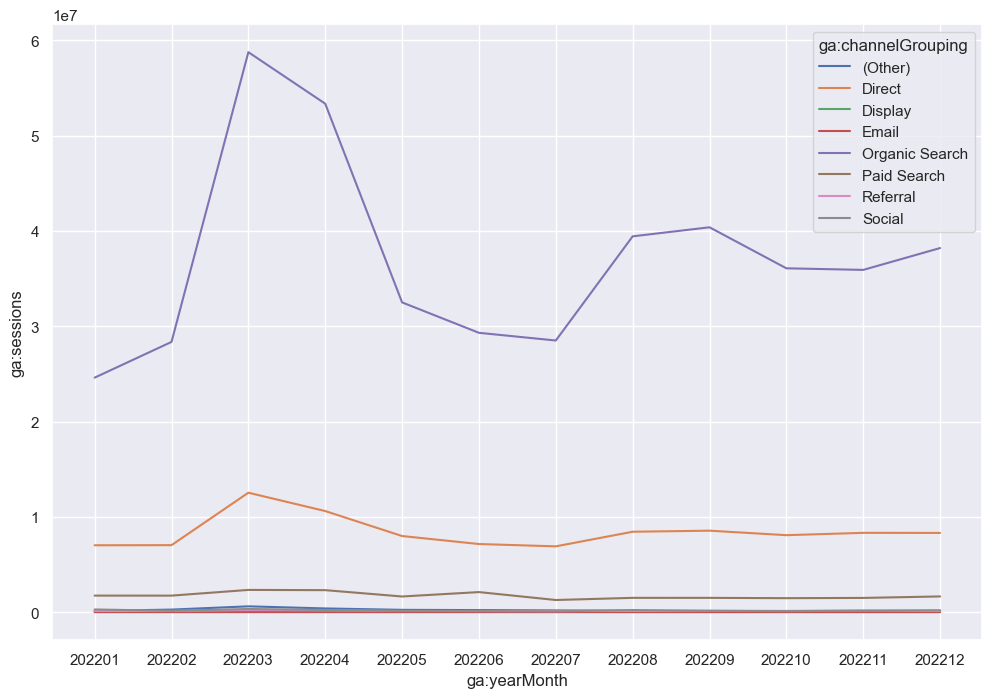

In [12]:
# Visualizamos las sesiones por mes
# ==============================================================================

sns.set(rc={'figure.figsize':(12,8)})
plot_data = report_month.loc[:, ["ga:users"]]
sns.lineplot(data = report_month, y = "ga:sessions", x = 'ga:yearMonth', hue = 'ga:channelGrouping');